In [1]:
!nvidia-smi
!pip install prefetch_generator
!pip install timm
!pip install albumentations

Thu Apr 27 00:14:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   22C    P8    22W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
import torchvision
import boto3
import io
import sagemaker
from sagemaker import get_execution_role
import tempfile
import PIL
import time
from datetime import timedelta
from prefetch_generator import BackgroundGenerator
import timm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import model_selection, metrics
from sklearn.metrics import accuracy_score

In [3]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


# Preprocessing

In [4]:
class MyDataset(Dataset):

    def __init__(self, df, transform=None):
        self.image_path = 'Dataset/train_images'
        self.labels = df
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.image_path + '/' + self.labels.iloc[idx]['image_id']

        # Read the image from the file path
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image=image)["image"]

        if "label" in self.labels.columns:
            label = self.labels.iloc[idx]['label']
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [5]:
train_transform = A.Compose([
            A.RandomResizedCrop(384, 384),
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.HueSaturationValue(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.CoarseDropout(p=0.5),
            A.Cutout(p=0.5),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [6]:
test_transform = A.Compose([
            A.RandomResizedCrop(384, 384),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [7]:
df = pd.read_csv('Dataset/train.csv')

train_df, test_df = model_selection.train_test_split(
    df, test_size=0.3, random_state=42, stratify=df.label.values
)

train_data = MyDataset(train_df, transform = train_transform)
test_data = MyDataset(test_df, transform = test_transform)

# Define our model

In [8]:
timm.list_models('*resnext*')

['bat_resnext26ts',
 'cspresnext50',
 'eca_resnext26ts',
 'ecaresnext26t_32x4d',
 'ecaresnext50t_32x4d',
 'gcresnext26ts',
 'gcresnext50ts',
 'gluon_resnext50_32x4d',
 'gluon_resnext101_32x4d',
 'gluon_resnext101_64x4d',
 'gluon_seresnext50_32x4d',
 'gluon_seresnext101_32x4d',
 'gluon_seresnext101_64x4d',
 'ig_resnext101_32x8d',
 'ig_resnext101_32x16d',
 'ig_resnext101_32x32d',
 'ig_resnext101_32x48d',
 'legacy_seresnext26_32x4d',
 'legacy_seresnext50_32x4d',
 'legacy_seresnext101_32x4d',
 'resnext26ts',
 'resnext50_32x4d',
 'resnext50d_32x4d',
 'resnext101_32x4d',
 'resnext101_32x8d',
 'resnext101_64x4d',
 'seresnext26d_32x4d',
 'seresnext26t_32x4d',
 'seresnext26tn_32x4d',
 'seresnext26ts',
 'seresnext50_32x4d',
 'seresnext101_32x4d',
 'seresnext101_32x8d',
 'seresnext101d_32x8d',
 'seresnextaa101d_32x8d',
 'skresnext50_32x4d',
 'ssl_resnext50_32x4d',
 'ssl_resnext101_32x4d',
 'ssl_resnext101_32x8d',
 'ssl_resnext101_32x16d',
 'swsl_resnext50_32x4d',
 'swsl_resnext101_32x4d',
 'swsl_

In [9]:
test_model = timm.create_model('resnext50_32x4d', pretrained=True)
test_model.default_cfg

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnext50_32x4d_a1h-0146ab0a.pth


{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnext50_32x4d_a1h-0146ab0a.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnext50_32x4d'}

In [10]:
class OurModel(nn.Module):
  def __init__(self, num_classes):
    super(OurModel, self).__init__()
    self.model = timm.create_model('resnext50_32x4d', pretrained=True)
    self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

  def forward(self, input):
    out = self.model(input)
    return out #F.softmax(out, dim=1)

# Loss Function

In [11]:
# ====================================================
# Label Smoothing
# ====================================================
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=5, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [12]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss()(inputs, targets)

        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [13]:
class FocalCosineLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, xent=.1):
        super(FocalCosineLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

        self.xent = xent

        self.y = torch.Tensor([1]).cuda()

    def forward(self, input, target, reduction="mean"):
        cosine_loss = F.cosine_embedding_loss(input, F.one_hot(target, num_classes=input.size(-1)), self.y, reduction=reduction)

        cent_loss = F.cross_entropy(F.normalize(input), target, reduce=False)
        pt = torch.exp(-cent_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * cent_loss

        if reduction == "mean":
            focal_loss = torch.mean(focal_loss)

        return cosine_loss + self.xent * focal_loss

In [14]:
class SymmetricCrossEntropy(nn.Module):

    def __init__(self, alpha=0.1, beta=1.0, num_classes=5):
        super(SymmetricCrossEntropy, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.num_classes = num_classes

    def forward(self, logits, targets, reduction='mean'):
        onehot_targets = torch.eye(self.num_classes)[targets].cuda()
        ce_loss = F.cross_entropy(logits, targets, reduction=reduction)
        rce_loss = (-onehot_targets*logits.softmax(1).clamp(1e-7, 1.0).log()).sum(1)
        if reduction == 'mean':
            rce_loss = rce_loss.mean()
        elif reduction == 'sum':
            rce_loss = rce_loss.sum()
        return self.alpha * ce_loss + self.beta * rce_loss

In [15]:
def log_t(u, t):
    """Compute log_t for `u'."""
    if t==1.0:
        return u.log()
    else:
        return (u.pow(1.0 - t) - 1.0) / (1.0 - t)

def exp_t(u, t):
    """Compute exp_t for `u'."""
    if t==1:
        return u.exp()
    else:
        return (1.0 + (1.0-t)*u).relu().pow(1.0 / (1.0 - t))

def compute_normalization_fixed_point(activations, t, num_iters):

    """Returns the normalization value for each example (t > 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same shape as activation with the last dimension being 1.
    """
    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations_step_0 = activations - mu

    normalized_activations = normalized_activations_step_0

    for _ in range(num_iters):
        logt_partition = torch.sum(
                exp_t(normalized_activations, t), -1, keepdim=True)
        normalized_activations = normalized_activations_step_0 * \
                logt_partition.pow(1.0-t)

    logt_partition = torch.sum(
            exp_t(normalized_activations, t), -1, keepdim=True)
    normalization_constants = - log_t(1.0 / logt_partition, t) + mu

    return normalization_constants

def compute_normalization_binary_search(activations, t, num_iters):

    """Returns the normalization value for each example (t < 1.0).
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (< 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """

    mu, _ = torch.max(activations, -1, keepdim=True)
    normalized_activations = activations - mu

    effective_dim = \
        torch.sum(
                (normalized_activations > -1.0 / (1.0-t)).to(torch.int32),
            dim=-1, keepdim=True).to(activations.dtype)

    shape_partition = activations.shape[:-1] + (1,)
    lower = torch.zeros(shape_partition, dtype=activations.dtype, device=activations.device)
    upper = -log_t(1.0/effective_dim, t) * torch.ones_like(lower)

    for _ in range(num_iters):
        logt_partition = (upper + lower)/2.0
        sum_probs = torch.sum(
                exp_t(normalized_activations - logt_partition, t),
                dim=-1, keepdim=True)
        update = (sum_probs < 1.0).to(activations.dtype)
        lower = torch.reshape(
                lower * update + (1.0-update) * logt_partition,
                shape_partition)
        upper = torch.reshape(
                upper * (1.0 - update) + update * logt_partition,
                shape_partition)

    logt_partition = (upper + lower)/2.0
    return logt_partition + mu

class ComputeNormalization(torch.autograd.Function):
    """
    Class implementing custom backward pass for compute_normalization. See compute_normalization.
    """
    @staticmethod
    def forward(ctx, activations, t, num_iters):
        if t < 1.0:
            normalization_constants = compute_normalization_binary_search(activations, t, num_iters)
        else:
            normalization_constants = compute_normalization_fixed_point(activations, t, num_iters)

        ctx.save_for_backward(activations, normalization_constants)
        ctx.t=t
        return normalization_constants

    @staticmethod
    def backward(ctx, grad_output):
        activations, normalization_constants = ctx.saved_tensors
        t = ctx.t
        normalized_activations = activations - normalization_constants 
        probabilities = exp_t(normalized_activations, t)
        escorts = probabilities.pow(t)
        escorts = escorts / escorts.sum(dim=-1, keepdim=True)
        grad_input = escorts * grad_output
        
        return grad_input, None, None

def compute_normalization(activations, t, num_iters=5):
    """Returns the normalization value for each example. 
    Backward pass is implemented.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      num_iters: Number of iterations to run the method.
    Return: A tensor of same rank as activation with the last dimension being 1.
    """
    return ComputeNormalization.apply(activations, t, num_iters)

def tempered_sigmoid(activations, t, num_iters = 5):
    """Tempered sigmoid function.
    Args:
      activations: Activations for the positive class for binary classification.
      t: Temperature tensor > 0.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_probabilities = tempered_softmax(internal_activations, t, num_iters)
    return internal_probabilities[..., 0]


def tempered_softmax(activations, t, num_iters=5):
    """Tempered softmax function.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      t: Temperature > 1.0.
      num_iters: Number of iterations to run the method.
    Returns:
      A probabilities tensor.
    """
    if t == 1.0:
        return activations.softmax(dim=-1)

    normalization_constants = compute_normalization(activations, t, num_iters)
    return exp_t(activations - normalization_constants, t)

def bi_tempered_binary_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing = 0.0,
        num_iters=5,
        reduction='mean'):

    """Bi-Tempered binary logistic loss.
    Args:
      activations: A tensor containing activations for class 1.
      labels: A tensor with shape as activations, containing probabilities for class 1
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing
      num_iters: Number of iterations to run the method.
    Returns:
      A loss tensor.
    """
    internal_activations = torch.stack([activations,
        torch.zeros_like(activations)],
        dim=-1)
    internal_labels = torch.stack([labels.to(activations.dtype),
        1.0 - labels.to(activations.dtype)],
        dim=-1)
    return bi_tempered_logistic_loss(internal_activations, 
            internal_labels,
            t1,
            t2,
            label_smoothing = label_smoothing,
            num_iters = num_iters,
            reduction = reduction)

def bi_tempered_logistic_loss(activations,
        labels,
        t1,
        t2,
        label_smoothing=0.0,
        num_iters=5,
        reduction = 'mean'):

    """Bi-Tempered Logistic Loss.
    Args:
      activations: A multi-dimensional tensor with last dimension `num_classes`.
      labels: A tensor with shape and dtype as activations (onehot), 
        or a long tensor of one dimension less than activations (pytorch standard)
      t1: Temperature 1 (< 1.0 for boundedness).
      t2: Temperature 2 (> 1.0 for tail heaviness, < 1.0 for finite support).
      label_smoothing: Label smoothing parameter between [0, 1). Default 0.0.
      num_iters: Number of iterations to run the method. Default 5.
      reduction: ``'none'`` | ``'mean'`` | ``'sum'``. Default ``'mean'``.
        ``'none'``: No reduction is applied, return shape is shape of
        activations without the last dimension.
        ``'mean'``: Loss is averaged over minibatch. Return shape (1,)
        ``'sum'``: Loss is summed over minibatch. Return shape (1,)
    Returns:
      A loss tensor.
    """

    if len(labels.shape)<len(activations.shape): #not one-hot
        labels_onehot = torch.zeros_like(activations)
        labels_onehot.scatter_(1, labels[..., None], 1)
    else:
        labels_onehot = labels

    if label_smoothing > 0:
        num_classes = labels_onehot.shape[-1]
        labels_onehot = ( 1 - label_smoothing * num_classes / (num_classes - 1) ) \
                * labels_onehot + \
                label_smoothing / (num_classes - 1)

    probabilities = tempered_softmax(activations, t2, num_iters)

    loss_values = labels_onehot * log_t(labels_onehot + 1e-10, t1) \
            - labels_onehot * log_t(probabilities, t1) \
            - labels_onehot.pow(2.0 - t1) / (2.0 - t1) \
            + probabilities.pow(2.0 - t1) / (2.0 - t1)
    loss_values = loss_values.sum(dim = -1) #sum over classes

    if reduction == 'none':
        return loss_values
    if reduction == 'sum':
        return loss_values.sum()
    if reduction == 'mean':
        return loss_values.mean()

In [16]:
class BiTemperedLogisticLoss(nn.Module): 
    def __init__(self, t1, t2, smoothing=0.0): 
        super(BiTemperedLogisticLoss, self).__init__() 
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing
    def forward(self, logit_label, truth_label):
        loss_label = bi_tempered_logistic_loss(
            logit_label, truth_label,
            t1=self.t1, t2=self.t2,
            label_smoothing=self.smoothing,
            reduction='none'
        )
        
        loss_label = loss_label.mean()
        return loss_label

In [17]:
class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out

    
class TaylorCrossEntropyLoss(nn.Module):
    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.05):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(5, smoothing=smoothing)

    def forward(self, logits, labels):
        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss

# Train our model

In [18]:
model = OurModel(5).cuda()
criterion = TaylorCrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6, amsgrad=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)

In [19]:
train_loader = DataLoader(dataset=train_data, batch_size = 32, shuffle= True, num_workers=4, pin_memory=True, drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size = 32, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

In [20]:
print('Start fine-tuning...')

Start fine-tuning...


In [21]:
def train_model(model, train_loader):
    epoch_loss = 0.
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1000)
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss
        
        if (i+1)%100==0:
            time_diff = get_run_time(start_time)
            print('Epoch [{}/{}]: Iter {}, Loss {:.4f}, Runtime {:.0f}m {:.0f}s'.format(epoch + 1, num_epochs, i + 1, loss, time_diff//60, time_diff%60))
            
    return epoch_loss/(i+1)

In [22]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        with torch.no_grad():
            outputs = model(images)
            
        outputs = outputs.softmax(1)
        
        _, prediction = torch.max(outputs.data, 1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)

    return correct/total * 100

In [23]:
def get_run_time(start_time):
    end_time = time.time()
    runtime = end_time - start_time
    return runtime

In [24]:
best_acc = 0.
best_epoch = None
end_patient = 0
num_epochs = 15

save_model_path = ''
train_loss = []
train_accuracy = []
test_accuracy = []

start_time = time.time()


for epoch in range(num_epochs):
    
    train_loss = train_model(model, train_loader)
    train_acc = test_model(model, train_loader)

    
    print('Testing on test dataset...')
    test_acc = test_model(model, test_loader)
    print('Epoch [{}/{}] Loss: {:.4f} Test_Acc: {:.4f}'
          .format(epoch + 1, num_epochs, train_loss, test_acc))
    
    scheduler.step()
    
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    if test_acc > best_acc:
        best_acc = test_acc
        best_epoch = epoch + 1
        print('The accuracy is improved, save model')
        torch.save(model.state_dict(), os.path.join(
                                                    'resnext50_tuning_epoch_%d_acc_%g.pth' %
                                                    (best_epoch, best_acc)))

print('After the training, the end of the epoch %d, the accuracy %g is the highest' % (best_epoch, best_acc))

Epoch [1/15]: Iter 100, Loss 0.8747, Runtime 2m 28s
Epoch [1/15]: Iter 200, Loss 0.8741, Runtime 3m 12s
Epoch [1/15]: Iter 300, Loss 1.0527, Runtime 3m 50s
Epoch [1/15]: Iter 400, Loss 0.8353, Runtime 4m 27s
Testing on test dataset...
Epoch [1/15] Loss: 0.9442 Test_Acc: 80.7165
The accuracy is improved, save model
Epoch [2/15]: Iter 100, Loss 0.5532, Runtime 6m 57s
Epoch [2/15]: Iter 200, Loss 0.6905, Runtime 7m 35s
Epoch [2/15]: Iter 300, Loss 0.7746, Runtime 8m 12s
Epoch [2/15]: Iter 400, Loss 0.6925, Runtime 8m 50s
Testing on test dataset...
Epoch [2/15] Loss: 0.6950 Test_Acc: 84.5171
The accuracy is improved, save model
Epoch [3/15]: Iter 100, Loss 0.5802, Runtime 11m 18s
Epoch [3/15]: Iter 200, Loss 0.6097, Runtime 11m 56s
Epoch [3/15]: Iter 300, Loss 0.7783, Runtime 12m 33s
Epoch [3/15]: Iter 400, Loss 0.4750, Runtime 13m 11s
Testing on test dataset...
Epoch [3/15] Loss: 0.6496 Test_Acc: 85.7165
The accuracy is improved, save model
Epoch [4/15]: Iter 100, Loss 0.6366, Runtime 15m

# Result Analysis

In [25]:
import matplotlib.pyplot as plt
import itertools

ValueError: x and y must have same first dimension, but have shapes (30,) and (15,)

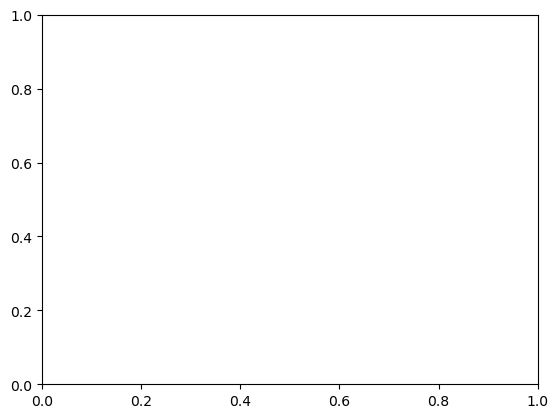

In [26]:
plt.plot(np.arange(1,31),train_accuracy,label='Train Accuracy')
plt.plot(np.arange(1,31),test_accuracy,label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Versus Epochs')
plt.show()

In [ ]:
model = OurModel(5).to(device)
model.load_state_dict(torch.load('resnext50_tuning_epoch_20_acc_87.1807.pth'))


In [ ]:
nb_classes = 5

confusion_matrix = torch.zeros(nb_classes, nb_classes)
model.eval()
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        #print(classes)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm/ np.sum(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2%' #if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
plt.figure()
num_classes=5
M = confusion_matrix.numpy()
plot_confusion_matrix(M, classes=np.arange(num_classes), normalize=True)
print("Accuracy:",np.trace(M/np.sum(M)))